In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#--export--#
from exports.e_08_LambdaLayers import *

# Hooks
## Manually

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input and output. Here we store the means and stddevs of each layer output in two lists.

In [3]:
class ManuallyHooked(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

### Convenience functions for building CNN

In [4]:
#--export--#
def conv_relu(n_inp, n_out, kernel_size=3, stride=2):
    return nn.Sequential(
            nn.Conv2d(n_inp, n_out,
                      kernel_size,
                      padding=kernel_size//2,
                      stride=stride),
            nn.ReLU())

    
def cnn_layers(data_w, n_kernels):
    n_kernels = [1] + n_kernels
    
    return [
        conv_relu(n_kernels[i], n_kernels[i+1], 5 if i==0 else 3)
        for i in range(len(n_kernels)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(n_kernels[-1], data_w.n_out)]

### Activation Means and Std Devs for each ReLU

In [5]:
kernel_ns = [8, 16, 32, 32]
data_w = MNISTDataWrapper()
model = ManuallyHooked(*cnn_layers(data_w, kernel_ns))

model_w = ModelWrapper(model,
                       optim.SGD(model.parameters(), lr=0.3),
                       torch.functional.F.cross_entropy,
                       data_w)

job = DLJob([AvgStatsCB(),
            BatchTransformCB(mnist_view)])
job.fit(1, model_w)

train: [2.19836453125]
valid: [1.3529533203125]


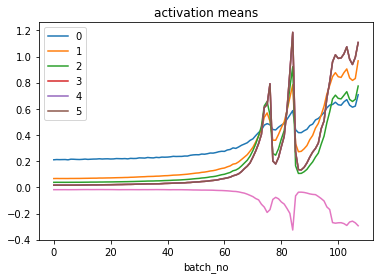

In [6]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6)); plt.xlabel('batch_no'); plt.title('activation means')
plt.show()

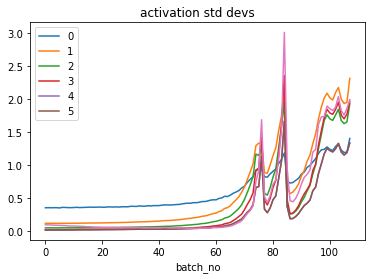

In [7]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6)); plt.xlabel('batch_no'); plt.title('activation std devs')
plt.show()

## Hooks Class
It's important to delete hooks when they are removed, otherwise references will be kept and the memory won't be properly released.

In [8]:
#--export--#
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()
        
def append_stats(hook, model, inp, out):
    if not hasattr(hook, 'stats'): hook.stats = ([],[])
    means, stds = hook.stats
    means.append(out.data.mean())
    stds .append(out.data.std())

In [9]:
model = nn.Sequential(*cnn_layers(data_w, kernel_ns))
model_w = ModelWrapper(model,
                       optim.SGD(model.parameters(), lr=0.3),
                       torch.functional.F.cross_entropy,
                       data_w)

job = DLJob([AvgStatsCB(),
            BatchTransformCB(mnist_view)])

In [10]:
hooks = [Hook(layer, append_stats) for layer in model[:4].children()]

In [11]:
job.fit(1, model_w)

train: [2.07925140625]
valid: [1.31772998046875]


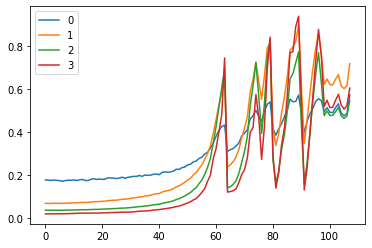

In [12]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4))
plt.show()

### ListContainer Helper Class

In [13]:
#--export--#
class ListContainer():
    def __init__(self, items): self.items = list(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int, slice)): return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx) == len(self)
            return [o for m,o in zip(idx, self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        rep = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self) > 10: rep = rep[:-1] + '...]'
        return rep

In [14]:
lc = ListContainer(range(100))
lc[[True]*4 + [False]*2 + [True]*2 + [False]*92]

[0, 1, 2, 3, 6, 7]

In [15]:
#--export--#
class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
        
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(self, i)
        
    def remove(self):
        for h in self: h.remove()

In [16]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f9c36fd03a0>, <__main__.Hook object at 0x7f9c36fd0970>, <__main__.Hook object at 0x7f9c36fd0280>, <__main__.Hook object at 0x7f9c36fd05b0>, <__main__.Hook object at 0x7f9c36fd0040>, <__main__.Hook object at 0x7f9c36fd0130>, <__main__.Hook object at 0x7f9c36fd09d0>]

In [17]:
hooks.remove()

train: [0.55626875]
valid: [0.2266552734375]


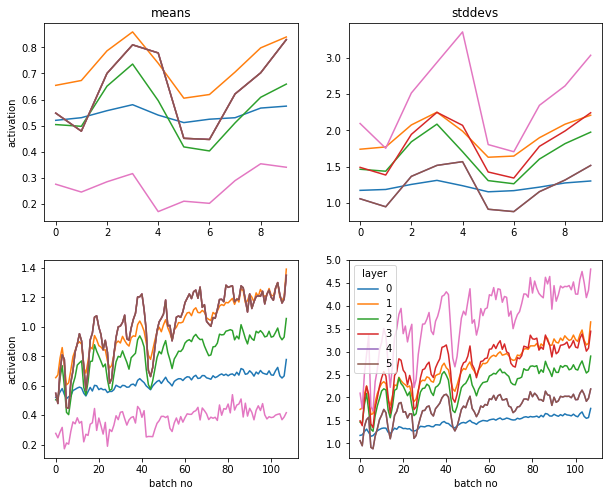

In [18]:
with Hooks(model, append_stats) as hooks:
    job.fit(1, model_w)
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    for h in hooks:
        means, stds = h.stats
        ax[0,0].plot(means[:10]); ax[0,1].plot(stds[:10])
        ax[1,0].plot(means); ax[1,1].plot(stds)
        ax[0,0].set_title('means'); ax[0,1].set_title('stddevs')
        for a in ax[1]: a.set_xlabel('batch no')
        for a in ax[:, 0]: a.set_ylabel('activation')
        plt.legend(range(6), title='layer')

In [19]:
!python utils/export_notebook.py 09_Hooks.ipynb

Notebook 09_Hooks.ipynb has been converted to module ./exports/e_09_Hooks.py!
